# Lab3: Homography, RANSAC, and Fundemental Matrix

We have gone through filtering, feature detection and description last week. For this week, we are gonna make attampts on using the extracted features to align images from planar scene for generating panaroma, triangulate world points in 3D, and estimating camera pose.


### At the moment this jupyter notebook only contain the first half of the lab sessions and the other half will be released before the next lab session.


## Part 1: Image Transformation

## Task 1: Image Transformations
Your first task is rather simple and just requires you to run an example.
The idea is just to show you a beneficial use of applying affine or perspective transformations to images and how this could be used in practice.

First load and show the images:


In [1]:
import numpy as np
import copy
import cv2
import matplotlib
from matplotlib import pyplot as plt
import random
import copy
from PIL import Image
#to visualize the plots within the notebook
# %matplotlib inline
# for making plots looking nicer
plt.style.use('fivethirtyeight')

In [29]:
# Load images
tag_img = cv2.imread('../dataset/plate_side.jpg') # Import image
tag_img = cv2.cvtColor(tag_img, cv2.COLOR_BGR2GRAY) # Convert to grayscale

ref_img = cv2.imread('../dataset/reference.jpg') # Import image
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY) # Convert to grayscale

%matplotlib tk 
plt.figure() # Create a new figure
plt.title("Reference image") # Title of the figure
plt.imshow(ref_img, 'gray') # Show the image
# Locate points of the documents or object which you want to transform into
ref_pts = plt.ginput(4) 
print(ref_pts)
plt.show()

# Locate points of the documents or object which you want to transform
plt.figure()
plt.title("Shot in real world")
plt.imshow(tag_img, 'gray')
tag_pts = plt.ginput(4)
print(tag_pts)
plt.show()
%matplotlib inline

[(np.float64(13.362068965517238), np.float64(15.672413793103459)), (np.float64(14.396551724137929), np.float64(66.36206896551725)), (np.float64(271.46551724137936), np.float64(16.189655172413808)), (np.float64(270.43103448275866), np.float64(63.77586206896552))]
[(np.float64(98.09259259259261), np.float64(88.09259259259258)), (np.float64(211.67283950617286), np.float64(102.9074074074074)), (np.float64(99.57407407407408), np.float64(112.29012345679011)), (np.float64(210.68518518518522), np.float64(137.9691358024691))]


The goal is to compute the 2D affine transformation that maps points from the source frame to the reference frame. The affine transformation consists of a linear transformation (rotation, scaling, and shearing) and a translation, requiring six degrees of freedom (6-DoF). We need at least 3 correspondences to solve this. We can get least square solution if more than 3 pair of correspondences are given.

$$
\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}a_{11} & a_{12} \\ a_{21} & a_{22}\end{bmatrix} \begin{bmatrix}x^{\prime} \\ y^{\prime}\end{bmatrix} + \begin{bmatrix}t_1 \\ t_2\end{bmatrix}
$$

$$
\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}a_{11} & a_{12} & t_1 \\ a_{21} & a_{22} & t_2\end{bmatrix} \begin{bmatrix}x^{\prime} \\ y^{\prime} \\ 1\end{bmatrix}
$$

$$
Y = AX
$$


In our example:
X is the tag image (Real Plate Image)
Y is the reference image (Empty Plate)

In [56]:
# Re-define Reference and Tag Points instead of using ginput
# Reference image: is the original (empty) plate image
# Tag image: is the image of the a actual car plate (with numbers and letters)


# Reference Points
# [(np.float64(13.879310344827587), np.float64(13.086206896551715)), (np.float64(270.948275862069), np.float64(17.741379310344826)), (np.float64(14.913793103448278), np.float64(66.87931034482759)), (np.float64(269.9137931034483), np.float64(66.87931034482759))]
ref_pts = np.array([[13.879310344827587, 13.086206896551715],
                    [270.948275862069, 17.741379310344826],
                    [14.913793103448278, 66.87931034482759],
                    [269.9137931034483, 66.87931034482759]])
# Tag Points
# [(np.float64(96.61111111111111), np.float64(88.09259259259258)), (np.float64(212.16666666666669), np.float64(104.38888888888889)), (np.float64(98.58641975308643), np.float64(113.27777777777777)), (np.float64(210.68518518518522), np.float64(139.4506172839506))]
tag_pts = np.array([[96.61111111111111, 88.09259259259258],
                    [212.16666666666669, 104.38888888888889],
                    [98.58641975308643, 113.27777777777777],
                    [210.68518518518522, 139.4506172839506]])


In [57]:
ref_pts = np.array(ref_pts)
tag_pts = np.array(tag_pts)

# Transpose the points
Y = ref_pts.T # [2, N] : Points in the reference image (empty plate)
X = tag_pts.T # [2, N] : Points in the tag image (car plate)
# Convert to homogeneous coordinates
X = np.concatenate([X, np.ones((1, X.shape[1]))], axis=0)  # [3, N]

## Task1.1: Call OpenCV function as reference result

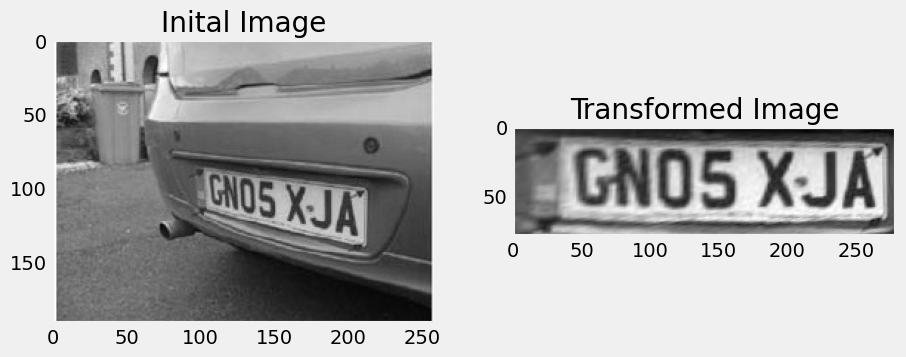

Solved transform matrix A:
[[ 5.90933095e+00 -4.13303406e-01 -5.11660792e+02]
 [-2.77967346e-01  3.45816840e+00 -2.56251977e+02]
 [ 8.34181682e-03 -1.82186277e-03  1.00000000e+00]] 

Transformed points before de-homogenising Ywrp :
[[ 22.83726856 698.95797444  24.10089822 675.7122783 ]
 [ 21.53230907  45.76697486 108.07784929 167.42813948]
 [  1.64541958   2.57967324   1.61601329   2.50343733]] 

Transformed points after de-homogenising Ywrp/Ywrp[2,:]:
[[ 13.87929794 270.94825965  14.91379953 269.91379778]
 [ 13.08621179  17.74138452  66.87930726  66.87930119]
 [  1.           1.           1.           1.        ]] 



In [ ]:
# switch to inline plot and we can see plots in the notebook
%matplotlib inline

# Apply Perspective Transform Algorithm
# Solve the transformation matrix: from tag image to reference image
A_ = cv2.getPerspectiveTransform(np.float32(tag_pts), np.float32(ref_pts))
# Use the transformation matrix to transform the tag image such that it looks like the reference image
wrp_img = cv2.warpPerspective(tag_img, A_, (280, 80))

# Plot Input, Output and Matched image
# Plot tag image 
plt.figure(figsize=(15,10))
plt.subplot(231) # 2 rows, 3 columns, 1st subplot
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

# Plot transformed image
plt.subplot(232) # 2 rows, 3 columns, 2nd subplot
plt.imshow(wrp_img, 'gray')
plt.grid(False)
plt.title('Transformed Image')
plt.show()

print("Solved transform matrix A:")
print(A_, "\n")

Ywrp_1 = A_ @ X # [3, N] : Transformed points
print("Transformed points before de-homogenising Ywrp :")
print(Ywrp_1, "\n")

Ywrp_1 /= Ywrp_1[2, :] # De-homogenise
print("Transformed points after de-homogenising Ywrp/Ywrp[2,:]:")
print(Ywrp_1, "\n")

## Task1.2: Solve affine matrix using least square.

Next, we solve the $2\times3$ affine matrix with our own solver based on standard-form least-square:

$$
\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}a_{11} & a_{12} & t_1 \\ a_{21} & a_{22} & t_2\end{bmatrix} \begin{bmatrix}x^{\prime} \\ y^{\prime} \\ 1\end{bmatrix}
$$

$$
\mathbf{y} = \mathbf{A} \mathbf{x}, \quad \text{where} \quad \mathbf{x} \in \mathbb{R}^{D_1}, \mathbf{y} \in \mathbb{R}^{D_2}
$$

Suppose we have $N$ correspondences. We can stack the vectors:

$$
\mathbf{Y} = \mathbf{A} \mathbf{X}, \quad \text{where} \quad \mathbf{X} \in \mathbb{R}^{D_1 \times N}, \mathbf{A} \in \mathbb{R}^{D_2 \times D_1}, \mathbf{Y} \in \mathbb{R}^{D_2 \times N}
$$

$\mathbf{A}$ could be solved by standard least-square (using Pseudoinverse Method)

$$
\mathbf{A} = \mathbf{Y} \mathbf{X}^T(\mathbf{X} \mathbf{X}^T)^{-1}
$$

In [58]:
#TODO Work out the affine matrix A from X and Y here:
# X = np.concatenate([X, np.ones((1, X.shape[1]))], axis=0)  # [3, N]
A = Y @ X.T @ np.linalg.inv(X @ X.T)

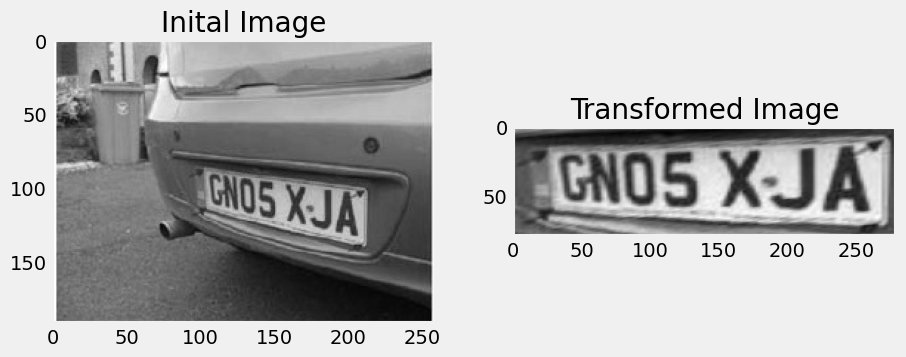

Solved transform matrix:
[[ 2.24927466e+00 -1.81830178e-03 -2.04924530e+02]
 [-2.85343474e-01  1.64721636e+00 -9.81036069e+01]] 

Transformed points before de-homogenising:
[[ 12.22021582 272.10676746  16.61743323 268.7107559 ]
 [ 19.43660279  13.30710496  60.35841045  71.48408869]] 



In [ ]:
Ywrp_2 = cv2.warpAffine(tag_img, A, (280, 80))
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(Ywrp_2, 'gray')
plt.grid(False)
plt.title('Transformed Image')
plt.show()

print("Solved transform matrix:")
print(A, "\n")
Y_ = A @ X
print("Transformed points before de-homogenising:")
print(Y_, "\n")

## Task1.3: Solve homography with DLT.
Finally, we solve the homography matrix (8-DoF) via DLT. DLT is to rewrite similarity equations $\mathbf{y} = \alpha\mathbf{A}\mathbf{x}$ as homogenous linear equation and solve.

$$
\begin{align}
    \begin{bmatrix}x \\ y \\ 1\end{bmatrix} = \alpha\begin{bmatrix}h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix}\begin{bmatrix}x^{\prime} \\ y^{\prime} \\ 1\end{bmatrix}
\end{align}
$$

Here we have two more DoFs and the solution is up to an unknown scale factor $\alpha$. More introduction about similarity equations and DLT can be found at: https://en.wikipedia.org/wiki/Direct_linear_transformation 

Expand the above equation and we get:

$$
\begin{align}
    x = \alpha (h_{11} x^{\prime} + h_{12} y^{\prime} + h_{13}) \\
    y = \alpha (h_{21} x^{\prime} + h_{22} y^{\prime} + h_{23}) \\
    1 = \alpha (h_{31} x^{\prime} + h_{32} y^{\prime} + h_{33}) \\
\end{align}
$$

Eliminate $\alpha$, by cross-multiplication, and dividing by alpha, then we get:

$$
\begin{align}
    (h_{31} x^{\prime} + h_{32} y^{\prime} + h_{33}) x = (h_{11} x^{\prime} + h_{12} y^{\prime} + h_{13}) \\
    (h_{31} x^{\prime} + h_{32} y^{\prime} + h_{33}) y = (h_{21} x^{\prime} + h_{22} y^{\prime} + h_{23}) \\
\end{align}
$$

$$
\begin{align}
    h_{31} xx^{\prime} + h_{32} xy^{\prime} + h_{33}x - h_{11} x^{\prime} - h_{12} y^{\prime} - h_{13} = 0 \\
    h_{31} yx^{\prime} + h_{32} yy^{\prime} + h_{33}y - h_{21} x^{\prime} - h_{22} y^{\prime} - h_{23} = 0 \\
\end{align}
$$

In matrix form:

$$
\mathbf{A}_i\mathbf{h} = \mathbf{0}
$$

$$
\mathbf{A}_i = \begin{bmatrix}-x^{\prime} & -y^{\prime} & -1 & 0 & 0 & 0 & xx^{\prime} & xy^{\prime} & x \\
0 & 0 & 0 & -x^{\prime} & -y^{\prime} & -1 & yx^{\prime} & yy^{\prime} & y
\end{bmatrix}
$$

$$
\mathbf{h} = \begin{bmatrix}h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h_{31} & h_{32} & h_{33}\end{bmatrix}^T
$$

This is a total least squares minimization problem which can be solved via SVD:

$$
\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T
$$

Choosing the last column of $\mathbf{V}$ to be $\mathbf{h}$

https://en.wikipedia.org/wiki/Singular_value_decomposition

In [124]:
# Workout homography matrix here:

##TODO First construct Ai from one point pair:
def construct_a_from_pts(ref, tag):
    x, y = ref
    xd, yd = tag

    Ai = np.array([[-xd, -yd, -1, 0, 0, 0, x*xd, x*yd, x],
                   [0, 0, 0, -xd, -yd, -1, y*xd, y*yd, y]])
    return Ai


##TODO Assmble A and solve it, 
n_pts = ref_pts.shape[0] # Number of points
A = np.zeros((2 * n_pts, 9))

for i in range(n_pts):
    print(f'ref_pts[i]: {ref_pts[i]}')
    print(f'tag_pts[i]: {tag_pts[i]}')
    A[2*i:2*i+2, :] = construct_a_from_pts(ref_pts[i], tag_pts[i]) 
    
    
##TODO Find V and construct H, remember normalization!
# use SVD to solve for M
U, S, V = np.linalg.svd(A)
H = V[-1, :].reshape(3, 3)

# Normalize H
H /= H[-1, -1]



ref_pts[i]: [13.87931034 13.0862069 ]
tag_pts[i]: [96.61111111 88.09259259]
ref_pts[i]: [270.94827586  17.74137931]
tag_pts[i]: [212.16666667 104.38888889]
ref_pts[i]: [14.9137931  66.87931034]
tag_pts[i]: [ 98.58641975 113.27777778]
ref_pts[i]: [269.9137931   66.87931034]
tag_pts[i]: [210.68518519 139.45061728]


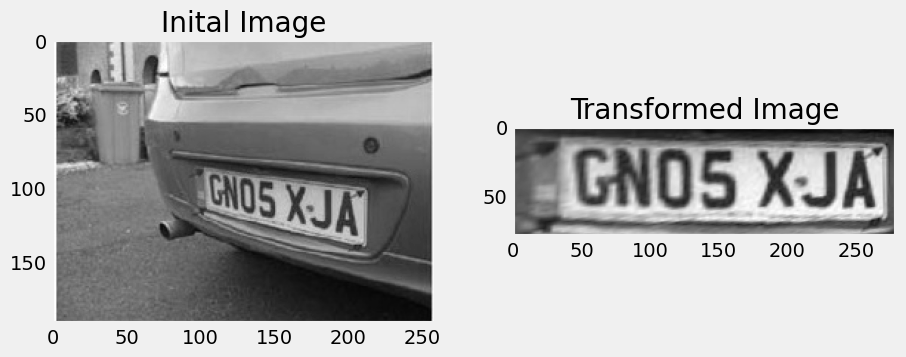

Solved transform matrix:
[[ 5.90932911e+00 -4.13304481e-01 -5.11660504e+02]
 [-2.77967473e-01  3.45816823e+00 -2.56251962e+02]
 [ 8.34181156e-03 -1.82186113e-03  1.00000000e+00]] 

Transformed points before de-homogenising:
[[ 22.83728391 698.95776044  24.10088288 675.71202931]
 [ 21.53229626  45.76694467 108.07783201 167.42810359]
 [  1.64541921   2.57967229   1.61601296   2.50343645]] 

Transformed points after de-homogenising:
[[ 13.87931034 270.94827586  14.9137931  269.9137931 ]
 [ 13.0862069   17.74137931  66.87931034  66.87931034]
 [  1.           1.           1.           1.        ]]


In [89]:

Ywrp_4 = cv2.warpPerspective(tag_img, H, (280, 80))
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(Ywrp_4, 'gray')
plt.grid(False)
plt.title('Transformed Image')
plt.show()

print("Solved transform matrix:")
print(H, "\n")
Y_ = H @ X
print("Transformed points before de-homogenising:")
print(Y_, "\n")
Y_ /= Y_[2, :]
print("Transformed points after de-homogenising:")
print(Y_)

## Part 2 Panaroma



## Task2 
The aim of Task2 is to calculate the homography that best maps two sets of points to one another. We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes. You should use this
template for your code and fill in the missing sections marked "TO DO."


## Import libraries 

In [101]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## Task 2.1 Test case formulation

To start with, let's set up some start points `pts1Cart` and a homography, `H`, that we can use to generate target points `pts2Cart`. We'll also add some noise to `pts2Cart` to simulate a real world environment. The challenge is to find the same homography, or as close as noise allows, given `pts1Cart` and `pts2Cart`.

__NOTE:__ It may be helpful to set `noiseLevel` to 0 to start with so that you can check if your solution is spot on while debugging. Make sure you set it back to some value, here we use 4, when you're confident your solution works.

In [ ]:
# Define a set of two-dimensional Cartesian points
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]])


# Convert points into homogeneous representation
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0) # pts1Hom = [3, N] : added row of ones

# Define a homography matrix
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]])

# Apply a homography to the points
pts2Hom = H @ pts1Hom # equivalent to np.matmul(H,pts1Hom) in 2D matrix multiplication

# Convert back to Cartesian coordinates
pts2Cart_num = pts2Hom[0:2,:] # First two rows of pts2Hom
pts2Cart_den = np.tile([pts2Hom[2,:]],(2,1)) # Third row of pts2Hom repeated twice
pts2Cart = pts2Cart_num / pts2Cart_den # Element-wise division: first two rows in ptsHom divided by the third row

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 4.0
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

## Plotting

Let's plot the the first original set of points, `pts1Cart`, in blue and the second set of points, `pts2Cart`, in red. 

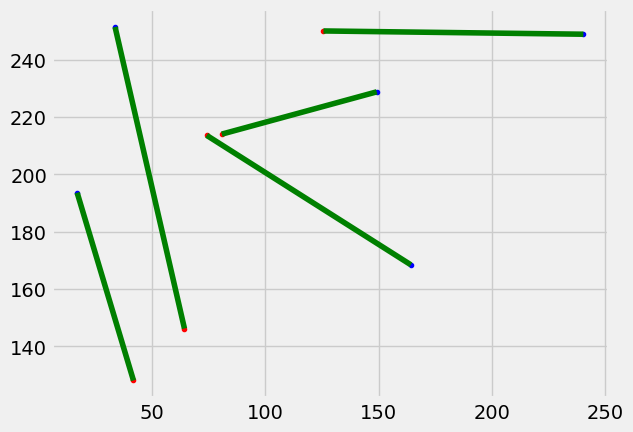

In [165]:
# Plot a green line between pairs of start points (blue) and transformed points (red).
nPoint = pts1Cart.shape[1] # Number of points to plot

for i in range(nPoint):
    # Start point (blue) : (x, y) = (pts1Cart[0,i], pts1Cart[1,i])
    # End point (red) : (x, y) = (pts2Cart[0,i], pts2Cart[1,i]) 
    plt.plot(pts1Cart[0,i],pts1Cart[1,i],'b.', 
             pts2Cart[0,i],pts2Cart[1,i],'r.') 
    
    # Draw a line (green) between the start and end points
    plt.plot([pts1Cart[0,i], pts2Cart[0,i]], 
             [pts1Cart[1,i], pts2Cart[1,i]],'g-') 

plt.show()

## Task 2.2 Homography estimation time!

We've formulated our test example; now our goal is to estimate the homography that maps the first set of points to the second set of points.

### ****TO DO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [166]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Check the task above.
    # Hint: SVD will be involved. 
   
    U, S, V = np.linalg.svd(A)
    h = V[-1, :] / V[-1, -1]
    
    return h

In [167]:
def calcBestHomography(pts1Cart, pts2Cart):
    

    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian points 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 
    #TODO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    n_points = pts1Cart.shape[1]
    A = np.zeros((2 * n_points, 9))

    for i in range(n_pts):
        A[2*i:2*i+2, :] = construct_a_from_pts(pts1Cart[:, i], pts2Cart[:, i])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    
    # Reshape h into the matrix H:
    #       [[h[0], h[1], h[2]]; 
    # H =    [h[3], h[4], h[5]]; 
    #        [h[6], h[7], h[8]]]
    H = h.reshape(3, 3)
    return H

## Test time!

Time to put it all together. 

Now we need a way of measuring how well our mapping does. 
To do this we will apply our estimated mapping, `H_est`, to `pts1Cart` and obtain estimated points `pts2EstCart`. 

We will compare `pts2EstCart` and `pts2Cart` using a sum of squared difference to see how well our solution at least approximates the transformed noisy points `pts2Cart`.

Red points on the plot are the noisy points we observe, `pts2Cart`, 
and the magenta points are the transformed points, `pts2EstCart`, that we get when we apply our estimated homography on `pts1Cart`. 
The black lines represent the error between both points; 

if you've set `noiseLevel` to 0, then `sqDiff` should be 0 and the points should overlap perfectly.

Sqaured difference between pts2Cart and pts2EstCart is: 91.56


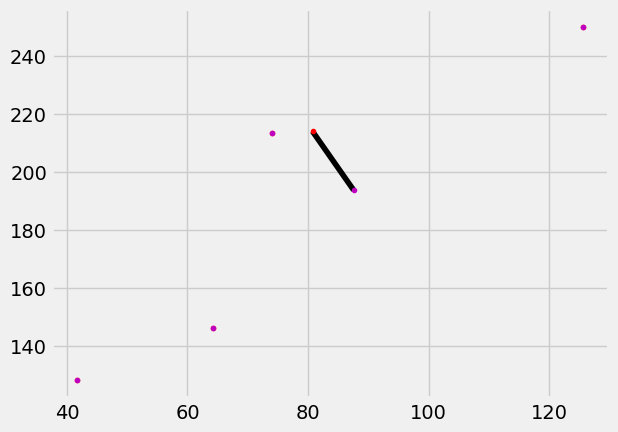

In [ ]:
# Replace this with a call to the function calcBestHomography. 
# You'll need to figure out which way around the points go in the function, 
# i.e. which direction this homography transforms points from and to. 
# The ordering is dead simple for now but acts as a simple exercise for what comes in later parts of this practical.

##########################################################################################
# Original points:      pts1Cart  
# transformed points:   pts2Cart
# Homography matrix:    H_est
# We want to transform pts1Cart back to pts2Cart
# pts2Cart is equivalent to ref_pts in the previous example
# pts1Cart is equivalent to tag_pts in the previous example
##########################################################################################
# Calculate the homography
H_est = calcBestHomography(pts2Cart, pts1Cart)

# Apply estimated homography to points
pts2EstHom = H_est @ pts1Hom #np.matmul(H_est,pts1Hom)

# Convert back to Cartesian coordinates
ptsEstCart_num = pts2EstHom[0:2,:] # First two rows of pts2Hom
ptsEstCart_den = np.tile([pts2EstHom[2,:]],(2,1)) # Third row of pts2Hom repeated twice
pts2EstCart = ptsEstCart_num / ptsEstCart_den # Element-wise division: first two rows in ptsHom divided by the third row

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for i in range(0, nPoint):
    plt.plot([pts2Cart[0,i], pts2EstCart[0,i]], [pts2Cart[1,i], pts2EstCart[1,i]],'k-')
    plt.plot(pts2Cart[0,i],pts2Cart[1,i],'r.',pts2EstCart[0,i],pts2EstCart[1,i],'m.') 

plt.show()

## Other things **** TO DO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).

Can you see why this is the case mathematically?

2: Show empirically that your homography routine can EXACTLY map any four points to any
other four points.

## Task 3
It's time to build something cool! One nice application of homographies is building a simple image stitcher for making panoramas. 

You'll reuse the routines you've written in part 1A (`calcBestHomography` and `solveAXEqualsZero`) again here, so feel free to copy over your functions directly. 

We're provided with three images. One large image, `im1`, is the target, i.e. we'll somehow transform and transfer two other images, `im2` and `im3` into this one.

We need some way of knowing how `im2` and `im3` map into `im1`. To that end, we'll assume a user (or a feature matching alogorithm) provided us with a sets of paired points. One set links points in `im1` to points in `im2`. The other set links `im1` and `im3` in the same manner. To perform the stitch, we'll find two homographies using these point pairs, one to translate between the space in `im1` and the space in `im2` and the other for `im1` and `im3`. 

The end result is worth it, so don't dispair!

## Import libraries 

In [193]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import time

## Loading and plotting images 

Red points show how `im2` and `im1` are related. Magenta points explain how `im1` and `im3` are related.

__NOTE:__ Before you get caught out, notice that the point pairs are in X, Y format, not in R, C format. In this convention, X points run along columns from left to right and Y points run along rows from top to bottom.

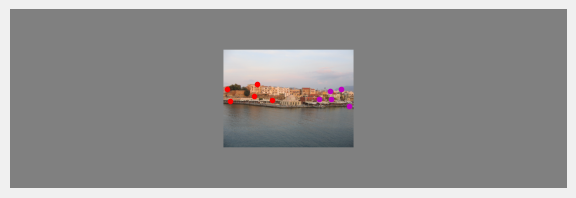

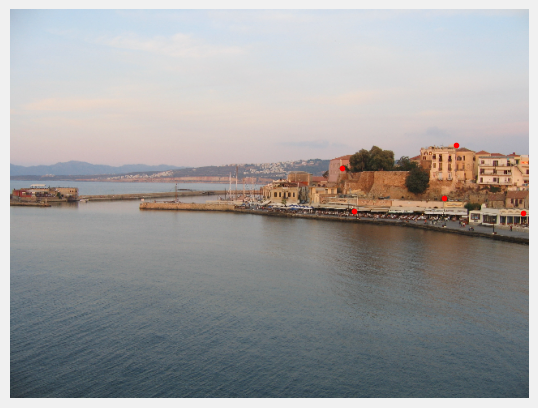

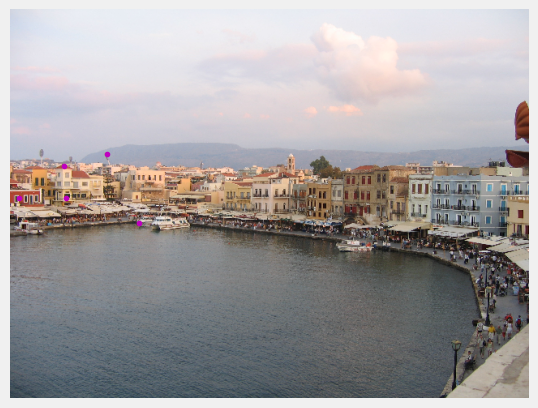

In [256]:
# Load data
data = sio.loadmat('../dataset/PracticalData.mat', squeeze_me = True)
# Unpack data

# im1 is center image with grey background. im1 has enough space to insert im2 and im3.
im1 = data['im1']

# im2 is left image 
im2 = data['im2']

# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']

# im3 is right image
im3 = data['im3']

# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Show images and points
plt.imshow(im1)
plt.plot(pts1[0,:],pts1[1,:],'r.')
plt.plot(pts1b[0,:],pts1b[1,:],'m.')
plt.axis('off')
plt.show()

plt.imshow(im2)
plt.plot(pts2[0,:],pts2[1,:],'r.')
plt.axis('off')
plt.show()

plt.imshow(im3)
plt.plot(pts3[0,:],pts3[1,:],'m.')
plt.axis('off')
plt.show()

## You should copy paste these functions from task2. 

In [257]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Check the task above.
    # Hint: SVD will be involved. 
   
    U, S, V = np.linalg.svd(A)
    h = V[-1, :] / V[-1, -1]
    
    return h

In [258]:
def calcBestHomography(pts1Cart, pts2Cart):
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian points 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 
    #TODO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    n_points = pts1Cart.shape[1]
    A = np.zeros((2 * n_points, 9))

    for i in range(n_pts):
        A[2*i:2*i+2, :] = construct_a_from_pts(pts1Cart[:, i], pts2Cart[:, i])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    
    # Reshape h into the matrix H:
    #       [[h[0], h[1], h[2]]; 
    # H =    [h[3], h[4], h[5]]; 
    #        [h[6], h[7], h[8]]]
    H = h.reshape(3, 3)
    
    return H

## The Process

Let's consider the first stitch, transforming and pasting `im2` into `im1`. 

We can loop over every location in `im1` and look in `im2` to see if there's a value we can paste in our image. 
The act of _looking_ into `im2` means that we need to translate from a location in `im1` to a location in `im2`. 
You can visualize this easily with the point correspondances already provided. 
For any other point in `im1`, we need a homography! 
You can use the function you've written before to generate this homography using `pts1` and `pts2`.


So now that we have a way of going from any location in `im1` to `im2`, we can loop over the locations in `im1`, get the corresponding positions in `im2` using the homography, and copy over that pixel value at each location from `im2` to `im1`.


There's one caveat, it's not always true that a transformed location from `im1` will be a valid index in `im2`, 
so for every index we need to check if it lies in the bounds of `im2`.

Don't worry if your solution takes a while to run. For loops aren't efficient. It might take anywhere from a minute to three for each stitch. 
You can make this much faster, but don't worry about that right now. 

Again, careful of how you translate between X-Y and R-C in your code when indexing; you've been warned! 

Sqaured difference between pts2Cart and pts2EstCart is: 2.37


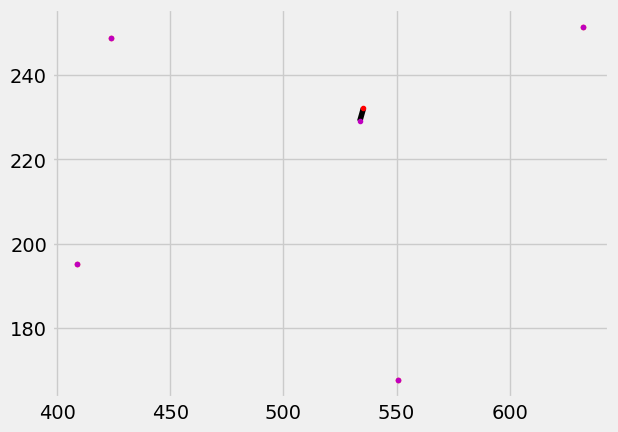

In [259]:
# Testing transformation of image 1 to image 2 on points pts1 and pts2

pts1Hom = np.concatenate((pts1, np.ones((1,pts1.shape[1]))), axis=0) # pts1Hom = [3, N] : added row of ones
pts2Hom = np.concatenate((pts2, np.ones((1,pts2.shape[1]))), axis=0) # pts2Hom = [3, N] : added row of ones

# Calculate the homography
H = calcBestHomography(pts2, pts1) # H maps points in image 1 to image 2
pts2EstHom = H @ pts1Hom # Map points in image 1 to image 2 using the estimated homography

# Convert back to Cartesian coordinates
ptsEst_num = pts2EstHom[0:2,:] # First two rows of pts2Hom
ptsEst_den = np.tile([pts2EstHom[2,:]],(2,1)) # Third row of pts2Hom repeated twice
pts2Est = ptsEst_num / ptsEst_den # Element-wise division: first two rows in ptsHom divided by the third row

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2 - pts2Est)**2))
print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for i in range(0, nPoint):
    plt.plot([pts2[0,i], pts2Est[0,i]], [pts2[1,i], pts2Est[1,i]],'k-')
    plt.plot(pts2[0,i],pts2[1,i],'r.',pts2Est[0,i],pts2Est[1,i],'m.') 
plt.show()

In [303]:
# Load data
data = sio.loadmat('../dataset/PracticalData.mat', squeeze_me = True)
# Unpack data

# im1 is center image with grey background. im1 has enough space to insert im2 and im3.
im1 = data['im1']

# im2 is left image 
im2 = data['im2']

# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']

# im3 is right image
im3 = data['im3']

# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Applying transformation to all pixels from image 1 to image 2 coordinates

# TO DO: Calculate homography from pts1 to pts2 
startTime = time.perf_counter()

# Image 1 is the center image, Image 2 is the left image
# Calculate the homography from image 2 to image 1 
#TODO: 
# For every pixel in image 1 (two loops):
    # Transform this pixel position with your homography to find where it is in the coordinates of image 2
    # Make sure you round the position using np.round since you'll use it as an index to a matrix.
    # If it the transformed position is within the boundary of image 2: 
    #     Copy pixel colour from image 2 pixel to current position in image 1 

    # Tranform pixels from image 1 (tag) to image 2 (ref)

pts1Hom = np.concatenate((pts1, np.ones((1,pts1.shape[1]))), axis=0) # pts1Hom = [3, N] : added row of ones
pts2Hom = np.concatenate((pts2, np.ones((1,pts2.shape[1]))), axis=0) # pts2Hom = [3, N] : added row of ones

# Calculate the homography
H = calcBestHomography(pts2, pts1) # H maps points in image 1 to image 2

h1, w1, _ = im1.shape
h2, w2, _ = im2.shape

im_holder = im1.copy()

for y1 in range(h1):
    for x1 in range(w1):
        # Transform pixel position with homography to find where it is in the coordinates of image 2
        pos1 = np.array([x1, y1, 1])
        pos2 = H @ pos1
        pos2 = pos2 / pos2[2]
        pos2 = np.round(pos2)
        pos2 = pos2.astype(int)
        x3, y2 = pos2[0], pos2[1]
    
        if 0 <= x3 < w2 and 0 <= y2 < h2:
            im_holder[y1, x1] = im2[y2, x3]


print("Stitching image 2 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))


Stitching image 2 to image 1 took: 5.14s


Stitching image 2 to image 1 took: 0.07s


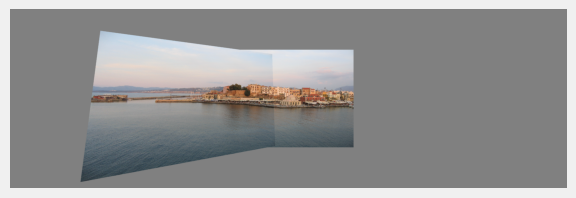

In [311]:
# Plot the intermediate panorama
plt.imshow(im_holder)
plt.axis('off')
plt.show()

In [306]:

# TO DO: Calculate homography from pts1 to pts2 
startTime = time.perf_counter()

# Calculate the homography
H = calcBestHomography(pts3, pts1b) # H maps points in image 1 to image 2

h1, w1, _ = im1.shape
h3, w3, _ = im3.shape

im_holder = im1.copy()

for y1 in range(h1):
    for x1 in range(w1):
        # Transform pixel position with homography to find where it is in the coordinates of image 2
        pos1 = np.array([x1, y1, 1])
        pos3 = H @ pos1
        pos3 = pos3 / pos3[2]
        pos3 = np.round(pos3)
        pos3 = pos3.astype(int)
        x3, y3 = pos3[0], pos3[1]
    
        if 0 <= x3 < w3 and 0 <= y3 < h3:
            im_holder[y1, x1] = im3[y3, x3]

print("Stitching image 2 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

Stitching image 2 to image 1 took: 5.24s


Stitching image 3 to image 1 took: 0.00s


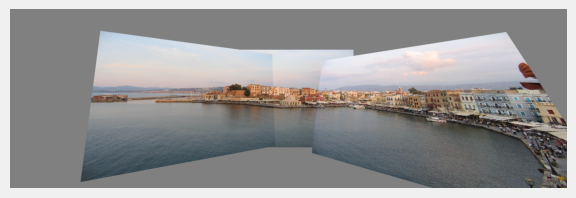

In [314]:
# Plot the final panorama
plt.imshow(im_holder)
plt.axis('off')
plt.show()

### _Fun_ task for those who have finished all above:


Do __NOT__ do this unless you've finished all four parts, want a challenge, and an exercise in numpy and vectorization. 

For loops are slow. Can you think of ways of making it faster with vectorized code? You can definitely bring it down to at least a second per stitch and maybe even lower. Speak to the TAs if you want, but you would need to figure this out for yourself as a good exercise.

### Task: How much time did you save?


In [324]:
# Load data
data = sio.loadmat('../dataset/PracticalData.mat', squeeze_me = True)
# Unpack data

# im1 is center image with grey background. im1 has enough space to insert im2 and im3.
im1 = data['im1']

# im2 is left image 
im3 = data['im2']

# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']

# im3 is right image
im3 = data['im3']

# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Create an empty holder for the output image
im_holder = im1.copy()


Stitching image 2 to image 1 took: 0.06s


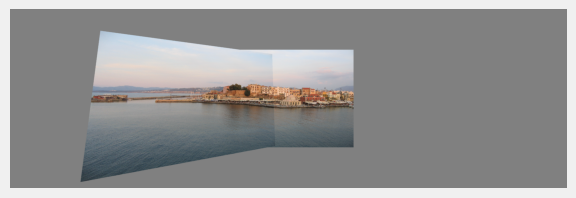

In [325]:
# Applying transformation to all pixels from image 1 to image 2 coordinates

# TO DO: Calculate homography from pts1 to pts2 
startTime = time.perf_counter()

# Image 1 is the center image, Image 2 is the left image
# Calculate the homography from image 2 to image 1 
#TODO: 
# For every pixel in image 1 (two loops):
    # Transform this pixel position with your homography to find where it is in the coordinates of image 2
    # Make sure you round the position using np.round since you'll use it as an index to a matrix.
    # If it the transformed position is within the boundary of image 2: 
    #     Copy pixel colour from image 2 pixel to current position in image 1 

    # Tranform pixels from image 1 (tag) to image 2 (ref)

pts1Hom = np.concatenate((pts1, np.ones((1,pts1.shape[1]))), axis=0) # pts1Hom = [3, N] : added row of ones
pts2Hom = np.concatenate((pts2, np.ones((1,pts2.shape[1]))), axis=0) # pts2Hom = [3, N] : added row of ones

# Calculate the homography
H = calcBestHomography(pts2, pts1) # H maps points in image 1 to image 2

# Assuming `im1` and `im2` are your input images, and `H` is the homography matrix
h1, w1, _ = im1.shape
h2, w2, _ = im3.shape

# Create a grid of all pixel coordinates in the source image
x1, y1 = np.meshgrid(np.arange(w1), np.arange(h1))
ones = np.ones_like(x1)
coords1 = np.stack([x1, y1, ones], axis=0)  # Shape: [3, h1, w1]

# Flatten the grid to [3, N] for matrix multiplication
coords1_flat = coords1.reshape(3, -1)

# Apply the homography
coords2_flat = H @ coords1_flat
coords2_flat /= coords2_flat[2]  # Normalize by the third (homogeneous) coordinate

# Round and convert to integer pixel indices
coords2 = np.round(coords2_flat[:2]).astype(int)  # Shape: [2, N]

# Extract valid coordinates
x2, y2 = coords2[0], coords2[1]
valid_mask = (0 <= x2) & (x2 < w2) & (0 <= y2) & (y2 < h2)

# Map valid pixels
im_holder[y1.flatten()[valid_mask], x1.flatten()[valid_mask]] = im2[y2[valid_mask], x2[valid_mask]]

print("Stitching image 2 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

# Plot the final panorama
plt.imshow(im_holder)
plt.axis('off')
plt.show()

Stitching image 3 to image 1 took: 0.00s


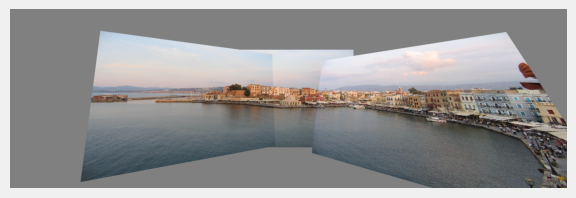

In [321]:
# TO DO: Repeat the above process mapping image 3 to image 1.

# Calculate the homography
H = calcBestHomography(pts3, pts1b) # H maps points in image 1 to image 3

# Assuming `im1` and `im2` are your input images, and `H` is the homography matrix
h1, w1, _ = im1.shape
h3, w3, _ = im3.shape

# Create a grid of all pixel coordinates in the source image
x1, y1 = np.meshgrid(np.arange(w1), np.arange(h1)) 
ones = np.ones_like(x1)
coords1 = np.stack([x1, y1, ones], axis=0)  # Shape: [3, h1, w1]

# Flatten the grid to [3, N] for matrix multiplication
coords1_flat = coords1.reshape(3, -1)

# Apply the homography
coords3_flat = H @ coords1_flat
coords3_flat /= coords3_flat[2]  # Normalize by the third (homogeneous) coordinate

# Round and convert to integer pixel indices
coords3 = np.round(coords3_flat[:2]).astype(int)  # Shape: [2, N]

# Extract valid coordinates
x3, y3 = coords3[0], coords3[1]
valid_mask = (0 <= x3) & (x3 < w3) & (0 <= y3) & (y3 < h3)

# Map valid pixels
im_holder[y1.flatten()[valid_mask], x1.flatten()[valid_mask]] = im3[y3[valid_mask], x3[valid_mask]]

startTime = time.perf_counter()
# loop and copy pixels...
print("Stitching image 3 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

# Plot the final panorama
plt.imshow(im_holder)
plt.axis('off')
plt.show()

Now, finalize and encapsule your implementation of sticking image together to a funciton for later use, vectorised stiching will save you a lot of time for the later tasks.


In [326]:
def stitch_image(im1, im2, H, direction='left'):
    """Stitch im2 into im1 using homography H"""
    # the direction argument is for logging only.
    startTime = time.perf_counter()

    h1, w1, _ = im1.shape
    h2, w2, _ = im2.shape

    # Create a grid of all pixel coordinates in the source image
    x1, y1 = np.meshgrid(np.arange(w1), np.arange(h1))
    ones = np.ones_like(x1)
    coords1 = np.stack([x1, y1, ones], axis=0)  # Shape: [3, h1, w1]

    # Flatten the grid to [3, N] for matrix multiplication
    coords1_flat = coords1.reshape(3, -1)

    # Apply the homography
    coords2_flat = H @ coords1_flat
    coords2_flat /= coords2_flat[2]  # Normalize by the third (homogeneous) coordinate

    # Round and convert to integer pixel indices
    coords2 = np.round(coords2_flat[:2]).astype(int)  # Shape: [2, N]

    # Extract valid coordinates
    x2, y2 = coords2[0], coords2[1]
    valid_mask = (0 <= x2) & (x2 < w2) & (0 <= y2) & (y2 < h2)

    # Map valid pixels
    im_holder[y1.flatten()[valid_mask], x1.flatten()[valid_mask]] = im2[y2[valid_mask], x2[valid_mask]]
        
    print(f"Stitching {direction} image took: {time.perf_counter() - startTime:.2f}s")
    return im1

## Task 4: Panorama Stitching with RANSAC

RANSAC (Random Sample Consensus) is an iterative algorithm for robust model estimation:
1. Randomly select minimum number of points needed (4 points for homography)
2. Calculate model (homography) using these points
3. Count how many other points agree with this model (inliers)
4. Repeat steps 1-3 many times
5. Keep the model with the most inliers

This helps remove incorrect matches (outliers) that would distort our homography estimation.

### Let's implement this step by step:

In [333]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random

In [332]:
#### Common Functions
def load_and_convert_image(img):
    """Convert image to grayscale and RGB formats"""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    return img_gray, img_rgb

def detect_and_match(img1_gray, img2_gray, max_features=1000, ratio_thresh=0.7):
    """Detect SIFT features and match between two images"""
    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=max_features)
    
    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    
    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
            
    return kp1, kp2, good_matches

def visualize_matches(img1_rgb, img2_rgb, kp1, kp2, matches, title="Feature Matches"):
    """Visualize matches between images"""
    match_img = cv2.drawMatches(
        img1_rgb, kp1,
        img2_rgb, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0)
    )
    
    plt.figure(figsize=(12, 6))
    plt.imshow(match_img)
    plt.title(f"{title}\n{len(matches)} matches")
    plt.axis('off')
    plt.show()


In [ ]:

def ransac_step1_select_points(kp1, kp2, matches):
    """Step 1: Randomly select 4 correspondences for RANSAC"""
    #TODO Convert keypoints to arrays
    
    #TODO Randomly select 4 correspondences

    return src_sample, dst_sample, src_pts, dst_pts

def ransac_step2_compute_inliers(src_sample, dst_sample, src_pts, dst_pts, threshold=4.0):
    """Step 2: Compute homography and calculate inliers"""
    # Compute homography using the selected 4 points
    H = cv2.getPerspectiveTransform(src_sample, dst_sample)

    #TODO Project source points using the homography


    #TODO Convert back to cartesian coordinates

    # Calculate distance between projected points and destination points

    distances = np.linalg.norm(projected_pts - dst_pts, axis=1)

    #TODO Count inliers


    return H, num_inliers, inlier_matches

def ransac_homography_manual(kp1, kp2, matches, threshold=4.0, max_iterations=2000):
    """Manually estimate homography using RANSAC"""

    # Initialize variables for the best model
    best_H = None
    max_inliers = 0
    inlier_matches = []

    for i in range(max_iterations):
        # Step 1: Select points
        src_sample, dst_sample, src_pts, dst_pts = ransac_step1_select_points(kp1, kp2, matches)

        # Step 2: Compute inliers
        H, num_inliers, current_inlier_matches = ransac_step2_compute_inliers(src_sample, dst_sample, src_pts, dst_pts, threshold)

        # Log current iteration details
        print(f"Iteration {i+1}/{max_iterations}, Num Inliers: {num_inliers}")

        #TODO Update the best model if it has more inliers


    print(f"Best model found with {max_inliers} inliers.")
    return best_H, inlier_matches


#### Load Images and Detect Features
Now we are putting everything together and try the previous example with know correspondence.

In [ ]:
# Load data
data = sio.loadmat('../dataset/PracticalData.mat', squeeze_me=True)
im1 = data['im1']  # center image
im2 = data['im2']  # left image
im3 = data['im3']  # right image

# Convert images
im1_gray, im1_rgb = load_and_convert_image(im1)
im2_gray, im2_rgb = load_and_convert_image(im2)
im3_gray, im3_rgb = load_and_convert_image(im3)

#### Match Features and Estimate Homographies
print("\n=== Matching Features between Images ===")

# Match im1 and im2
t0 = time.time()
kp1_2, kp2, matches1_2 = detect_and_match(im1_gray, im2_gray)
H1to2, inliers1_2 = ransac_homography_manual(kp1_2, kp2, matches1_2)
print(f"Image 1-2 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers1_2)} inliers out of {len(matches1_2)} matches")

# Match im1 and im3
t0 = time.time()
kp1_3, kp3, matches1_3 = detect_and_match(im1_gray, im3_gray)
H1to3, inliers1_3 = ransac_homography_manual(kp1_3, kp3, matches1_3)
print(f"Image 1-3 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers1_3)} inliers out of {len(matches1_3)} matches")

# Visualize matches
visualize_matches(im1_rgb, im2_rgb, kp1_2, kp2, inliers1_2, "Image 1-2 Inlier Matches")
visualize_matches(im1_rgb, im3_rgb, kp1_3, kp3, inliers1_3, "Image 1-3 Inlier Matches")



# Stitch images
result = im1.copy()
result = stitch_image(result, im2, H1to2, 'left')
result = stitch_image(result, im3, H1to3, 'right')

# Display final panorama
plt.figure(figsize=(15, 8))
plt.imshow(result)
plt.title("Final Panorama using SIFT and RANSAC")
plt.axis('off')
plt.show()



=== Matching Features between Images ===


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:3624: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'


### Task: Try capture your own images and stich to panorama.
One panorama with at least 5 images is sufficient, the current example hardcodes 3 images, can you read from all images in a directory?

What else do you need to change to recover the complete panorama?

hint: You might need to make your canvas larger for more images.

In [ ]:

im1 = cv2.imread('001.jpg', cv2.IMREAD_COLOR)  # Read the center image
im3 = cv2.imread('002.jpg', cv2.IMREAD_COLOR)  # Read the left image
im3 = cv2.imread('003.jpg', cv2.IMREAD_COLOR)  # Read the right image

# Convert images
im1_gray, im1_rgb = load_and_convert_image(im1)
im2_gray, im2_rgb = load_and_convert_image(im3)
im3_gray, im3_rgb = load_and_convert_image(im3)

#### Match Features and Estimate Homographies
print("\n=== Matching Features between Images ===")

# Match im1 and im2
t0 = time.time()
kp1_2, kp2, matches1_2 = detect_and_match(im1_gray, im2_gray)
H1to2, inliers1_2 = ransac_homography_manual(kp1_2, kp2, matches1_2)
print(f"Image 1-2 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers1_2)} inliers out of {len(matches1_2)} matches")

# Match im1 and im3
t0 = time.time()
kp1_3, kp3, matches1_3 = detect_and_match(im1_gray, im3_gray)
H1to3, inliers1_3 = ransac_homography_manual(kp1_3, kp3, matches1_3)
print(f"Image 1-3 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers1_3)} inliers out of {len(matches1_3)} matches")

# Visualize matches
visualize_matches(im1_rgb, im2_rgb, kp1_2, kp2, inliers1_2, "Image 1-2 Inlier Matches")
visualize_matches(im1_rgb, im3_rgb, kp1_3, kp3, inliers1_3, "Image 1-3 Inlier Matches")



# Stitch images
result = im1.copy()
result = stitch_image(result, im3, H1to2, 'left')
result = stitch_image(result, im3, H1to3, 'right')

# Display final panorama
plt.figure(figsize=(15, 8))
plt.imshow(result)
plt.title("Final Panorama using SIFT and RANSAC")
plt.axis('off')
plt.show()
